In [1]:
!pip install -q pyspark


from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window


spark = SparkSession.builder.appName("Movie-Capstone").getOrCreate()
sc = spark.sparkContext

In [2]:
users_data = [
(1, "Rahul", 25, "Bangalore"),
(2, "Priya", 30, "Delhi"),
(3, "Aman", 22, "Hyderabad"),
(4, "Sneha", 28, "Chennai"),
(5, "Arjun", 35, "Mumbai")
]
users_cols = ["user_id", "name", "age", "city"]
users_df = spark.createDataFrame(users_data, users_cols)

In [3]:
movies_data = [
(101, "Inception", "Sci-Fi", 2010),
(102, "Avengers", "Action", 2012),
(103, "3 Idiots", "Comedy", 2009),
(104, "Dangal", "Drama", 2016),
(105, "Interstellar", "Sci-Fi", 2014)
]
movies_cols = ["movie_id", "title", "genre", "year"]
movies_df = spark.createDataFrame(movies_data, movies_cols)

In [4]:
ratings_data = [
(1, 101, 5),
(2, 101, 4),
(1, 102, 3),
(3, 103, 4),
(4, 104, 5),
(2, 103, 5),
(5, 105, 4),
(6, 101, 5) # Rating from non-existent user (user_id = 6)
]
ratings_cols = ["user_id", "movie_id", "rating"]
ratings_df = spark.createDataFrame(ratings_data, ratings_cols)


print("Data prepared.\n")

Data prepared.



In [5]:
print("Users:")
users_df.show()
print("Movies:")
movies_df.show()
print("Ratings:")
ratings_df.show()

Users:
+-------+-----+---+---------+
|user_id| name|age|     city|
+-------+-----+---+---------+
|      1|Rahul| 25|Bangalore|
|      2|Priya| 30|    Delhi|
|      3| Aman| 22|Hyderabad|
|      4|Sneha| 28|  Chennai|
|      5|Arjun| 35|   Mumbai|
+-------+-----+---+---------+

Movies:
+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     101|   Inception|Sci-Fi|2010|
|     102|    Avengers|Action|2012|
|     103|    3 Idiots|Comedy|2009|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+

Ratings:
+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|     101|     5|
|      2|     101|     4|
|      1|     102|     3|
|      3|     103|     4|
|      4|     104|     5|
|      2|     103|     5|
|      5|     105|     4|
|      6|     101|     5|
+-------+--------+------+



In [6]:
older_than_28 = users_df.filter(F.col("age") > 28)
print("Users older than 28:")
older_than_28.show()


distinct_genres = movies_df.select("genre").distinct()
print("Distinct movie genres:")
distinct_genres.show()


movies_after_2010 = movies_df.filter(F.col("year") > 2010)
print("Movies released after 2010:")
movies_after_2010.show()

Users older than 28:
+-------+-----+---+------+
|user_id| name|age|  city|
+-------+-----+---+------+
|      2|Priya| 30| Delhi|
|      5|Arjun| 35|Mumbai|
+-------+-----+---+------+

Distinct movie genres:
+------+
| genre|
+------+
|Action|
|Sci-Fi|
| Drama|
|Comedy|
+------+

Movies released after 2010:
+--------+------------+------+----+
|movie_id|       title| genre|year|
+--------+------------+------+----+
|     102|    Avengers|Action|2012|
|     104|      Dangal| Drama|2016|
|     105|Interstellar|Sci-Fi|2014|
+--------+------------+------+----+



In [7]:
avg_age_per_city = users_df.groupBy("city").agg(F.round(F.avg("age"),2).alias("avg_age"))
print("Average age of users per city:")
avg_age_per_city.show()


avg_rating_per_movie = ratings_df.groupBy("movie_id").agg(F.round(F.avg("rating"),2).alias("avg_rating"))
print("Average rating per movie (movie_id):")
avg_rating_per_movie.show()
avg_rating_with_title = avg_rating_per_movie.join(movies_df, on="movie_id", how="left").select("movie_id","title","avg_rating")
print("Average rating per movie (with title):")
avf = avg_rating_with_title
avf.show()

avg_movie_ratings = ratings_df.groupBy("movie_id").agg(F.avg("rating").alias("avg_rating"))
avg_movie_with_meta = avg_movie_ratings.join(movies_df, on="movie_id", how="left")
w = Window.partitionBy("genre").orderBy(F.desc("avg_rating"), F.asc("movie_id"))
ranked = avg_movie_with_meta.withColumn("rank", F.row_number().over(w))
top_per_genre = ranked.filter(F.col("rank") == 1).select("genre","movie_id","title",F.round(F.col("avg_rating"),2).alias("avg_rating"))
print("Highest-rated movie in each genre (by average rating):")
top_per_genre.show()

Average age of users per city:
+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   25.0|
|    Delhi|   30.0|
|  Chennai|   28.0|
|   Mumbai|   35.0|
|Hyderabad|   22.0|
+---------+-------+

Average rating per movie (movie_id):
+--------+----------+
|movie_id|avg_rating|
+--------+----------+
|     103|       4.5|
|     101|      4.67|
|     102|       3.0|
|     104|       5.0|
|     105|       4.0|
+--------+----------+

Average rating per movie (with title):
+--------+------------+----------+
|movie_id|       title|avg_rating|
+--------+------------+----------+
|     103|    3 Idiots|       4.5|
|     101|   Inception|      4.67|
|     102|    Avengers|       3.0|
|     104|      Dangal|       5.0|
|     105|Interstellar|       4.0|
+--------+------------+----------+

Highest-rated movie in each genre (by average rating):
+------+--------+---------+----------+
| genre|movie_id|    title|avg_rating|
+------+--------+---------+----------+
|Action|     102| Avenger

In [8]:
ratings_users = ratings_df.join(users_df, on="user_id", how="left").select("user_id","name","movie_id","rating")
print("Ratings joined with users (who rated what):")
ratings_users.show()


ratings_movies = ratings_df.join(movies_df, on="movie_id", how="left").select("movie_id","title","user_id","rating")
print("Ratings joined with movies (ratings with movie names):")
ratings_movies.show()


users_no_ratings = users_df.join(ratings_df, on="user_id", how="left_anti")
print("Users who have not rated any movie:")
users_no_ratings.show()


movies_no_ratings = movies_df.join(ratings_df, on="movie_id", how="left_anti")
print("Movies that have never been rated:")
movies_no_ratings.show()


print("Ratings with unknown users (user_id not in users table):")
unknown_user_ratings = ratings_df.join(users_df, on="user_id", how="left_anti")
unknown_user_ratings.show()

Ratings joined with users (who rated what):
+-------+-----+--------+------+
|user_id| name|movie_id|rating|
+-------+-----+--------+------+
|      1|Rahul|     101|     5|
|      1|Rahul|     102|     3|
|      3| Aman|     103|     4|
|      2|Priya|     101|     4|
|      6| NULL|     101|     5|
|      5|Arjun|     105|     4|
|      2|Priya|     103|     5|
|      4|Sneha|     104|     5|
+-------+-----+--------+------+

Ratings joined with movies (ratings with movie names):
+--------+------------+-------+------+
|movie_id|       title|user_id|rating|
+--------+------------+-------+------+
|     103|    3 Idiots|      3|     4|
|     101|   Inception|      1|     5|
|     101|   Inception|      2|     4|
|     102|    Avengers|      1|     3|
|     103|    3 Idiots|      2|     5|
|     104|      Dangal|      4|     5|
|     105|Interstellar|      5|     4|
|     101|   Inception|      6|     5|
+--------+------------+-------+------+

Users who have not rated any movie:
+-------+--

In [9]:
users_df.createOrReplaceTempView("users")
movies_df.createOrReplaceTempView("movies")
ratings_df.createOrReplaceTempView("ratings")
print("Temp views registered: users, movies, ratings")


sql_top2_cities = spark.sql("""
SELECT u.city, COUNT(r.rating) AS ratings_count
FROM ratings r
JOIN users u ON r.user_id = u.user_id
GROUP BY u.city
ORDER BY ratings_count DESC
LIMIT 2
""")
print("Top 2 cities by number of ratings (SQL):")
sql_top2_cities.show()


sql_users_with_5 = spark.sql("""
SELECT DISTINCT u.user_id, u.name
FROM users u
JOIN ratings r ON u.user_id = r.user_id
WHERE r.rating = 5
""")
print("Users who gave at least one 5-star rating (SQL):")
sql_users_with_5.show()


sql_popular_genre = spark.sql("""
SELECT m.genre, COUNT(r.rating) AS ratings_count
FROM ratings r
JOIN movies m ON r.movie_id = m.movie_id
GROUP BY m.genre
ORDER BY ratings_count DESC
LIMIT 1
""")
print("Most popular genre by number of ratings (SQL):")
sql_popular_genre.show()

Temp views registered: users, movies, ratings
Top 2 cities by number of ratings (SQL):
+---------+-------------+
|     city|ratings_count|
+---------+-------------+
|Bangalore|            2|
|    Delhi|            2|
+---------+-------------+

Users who gave at least one 5-star rating (SQL):
+-------+-----+
|user_id| name|
+-------+-----+
|      1|Rahul|
|      2|Priya|
|      4|Sneha|
+-------+-----+

Most popular genre by number of ratings (SQL):
+------+-------------+
| genre|ratings_count|
+------+-------------+
|Sci-Fi|            4|
+------+-------------+



In [10]:
ratings_csv_path = "/content/ratings_output_csv"
ratings_df.write.mode("overwrite").option("header", True).csv(ratings_csv_path)
print(f"Ratings saved as CSV at: {ratings_csv_path}")
ratings_loaded_csv = spark.read.option("header", True).csv(ratings_csv_path)
print("Ratings loaded back from CSV (schema and sample):")
ratings_loaded_csv.printSchema()
ratings_loaded_csv.show()


movies_json_path = "/content/movies_output_json"
movies_df.write.mode("overwrite").json(movies_json_path)
print(f"Movies saved as JSON at: {movies_json_path}")
movies_loaded_json = spark.read.json(movies_json_path)
print("Movies loaded back from JSON:")
movies_loaded_json.show()

Ratings saved as CSV at: /content/ratings_output_csv
Ratings loaded back from CSV (schema and sample):
root
 |-- user_id: string (nullable = true)
 |-- movie_id: string (nullable = true)
 |-- rating: string (nullable = true)

+-------+--------+------+
|user_id|movie_id|rating|
+-------+--------+------+
|      1|     101|     5|
|      2|     101|     4|
|      1|     102|     3|
|      3|     103|     4|
|      4|     104|     5|
|      2|     103|     5|
|      5|     105|     4|
|      6|     101|     5|
+-------+--------+------+

Movies saved as JSON at: /content/movies_output_json
Movies loaded back from JSON:
+------+--------+------------+----+
| genre|movie_id|       title|year|
+------+--------+------------+----+
|Comedy|     103|    3 Idiots|2009|
| Drama|     104|      Dangal|2016|
|Sci-Fi|     105|Interstellar|2014|
|Sci-Fi|     101|   Inception|2010|
|Action|     102|    Avengers|2012|
+------+--------+------------+----+



Pandas dataframe for avg rating per genre:
    genre  avg_rating
0  Action         3.0
1  Comedy         4.5
2   Drama         5.0
3  Sci-Fi         4.5


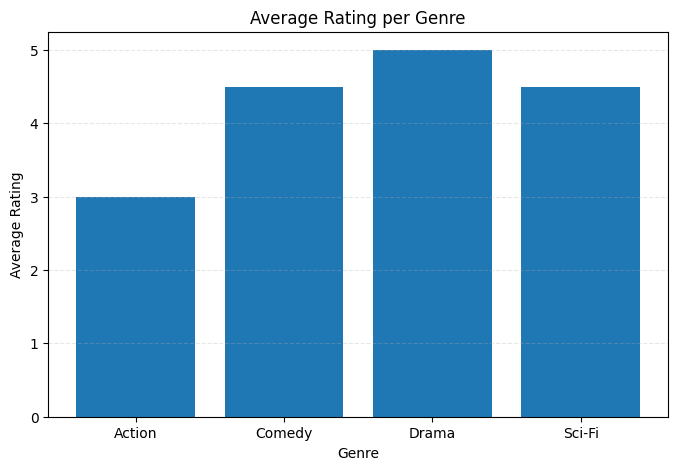

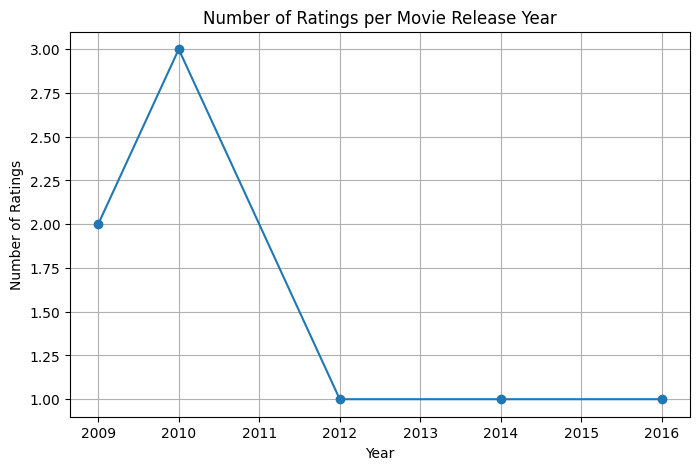

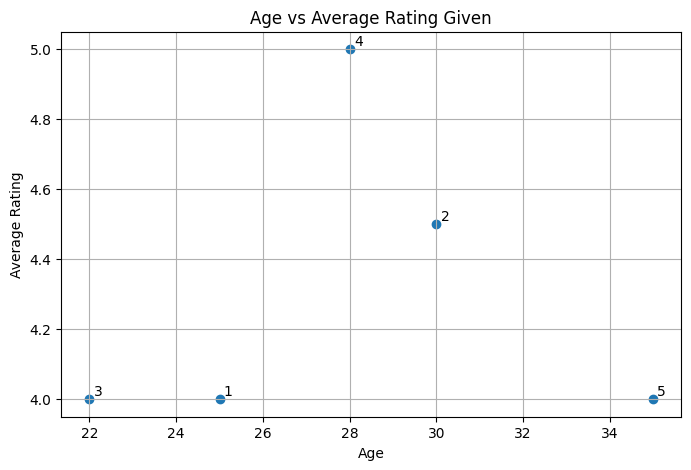

Notebook run completed. If running in Colab, inspect /content/ for saved CSV/JSON.


In [12]:
pd_avg_rating_genre = (ratings_df.join(movies_df, on="movie_id", how="left")
.groupBy("genre").agg(F.avg("rating").alias("avg_rating"))
.orderBy("genre")
.toPandas())
print("Pandas dataframe for avg rating per genre:")
print(pd_avg_rating_genre)

import matplotlib.pyplot as plt


plt.figure(figsize=(8,5))
plt.bar(pd_avg_rating_genre['genre'], pd_avg_rating_genre['avg_rating'])
plt.title('Average Rating per Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


pd_ratings_per_year = (ratings_df.join(movies_df, on='movie_id', how='left')
.groupBy('year').agg(F.count('rating').alias('ratings_count'))
.orderBy('year')
.toPandas())


plt.figure(figsize=(8,5))
plt.plot(pd_ratings_per_year['year'], pd_ratings_per_year['ratings_count'], marker='o')
plt.title('Number of Ratings per Movie Release Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()


pd_age_avg_rating = (ratings_df.join(users_df, on='user_id', how='left')
.groupBy('user_id','age')
.agg(F.avg('rating').alias('avg_rating'))
.orderBy('user_id')
.toPandas())


plt.figure(figsize=(8,5))
plt.scatter(pd_age_avg_rating['age'], pd_age_avg_rating['avg_rating'])
for i, row in pd_age_avg_rating.iterrows():
  plt.text(row['age']+0.1, row['avg_rating']+0.01, str(int(row['user_id'])))
plt.title('Age vs Average Rating Given')
plt.xlabel('Age')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()


print("Notebook run completed. If running in Colab, inspect /content/ for saved CSV/JSON.")